#Install needed libraries

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

path = "/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1/"
%cd {path}
!ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1


In [ ]:
!git clone https://github.com/phamdinhkhanh/vnquant
%cd vnquant
!python setup.py install

Cloning into 'vnquant'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 341 (delta 65), reused 89 (delta 53), pack-reused 237
Receiving objects: 100% (341/341), 1.05 MiB | 5.52 MiB/s, done.
Resolving deltas: 100% (164/164), done.
/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1/vnquant
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/

In [ ]:
%cd ..
!rm -rf vnquant
!ls

/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1


In [ ]:
!pip freeze | grep vnquant

vnquant==0.1.1


In [ ]:
import vnquant
vnquant.__version__

'0.1.1'

In [ ]:
!pip install plotly
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.9 MB/s eta 0:00:00


In [ ]:
import vnquant.data as dt
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima, ndiffs
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

#We choose 10 codes from biggest companies on stock exchange in Vietnam

In [ ]:
stock_symbols = ['VIC', 'VCB', 'VNM', 'GAS', 'HVN', 'MWG', 'FPT', 'HPG', 'MSN', 'SAB']
print(stock_symbols)

['VIC', 'VCB', 'VNM', 'GAS', 'HVN', 'MWG', 'FPT', 'HPG', 'MSN', 'SAB']


#Prepare the dataset

In [ ]:
stock_data = {}
for i in range(len(stock_symbols)):
  data = dt.DataLoader(symbols=stock_symbols[i],
                        start="2014-01-01",
                        end="2024-01-01",
                        data_source="VND")
  stock_data[stock_symbols[i]] = data.download()

In [ ]:
stock_data[stock_symbols[0]]

Attributes,high,low,open,close,avg,volume
Symbols,VIC,VIC,VIC,VIC,VIC,VIC
date,,,,,,
2014-01-02,70.50,69.50,70.00,70.00,69.92,74950.0
2014-01-03,70.50,69.50,70.00,70.50,70.00,91920.0
2014-01-06,70.50,69.50,70.50,70.50,70.11,111760.0
2014-01-07,70.50,70.00,70.50,70.50,70.47,294120.0
2014-01-08,70.50,70.00,70.00,70.00,70.02,109890.0
...,...,...,...,...,...,...
2023-12-25,43.55,43.00,43.10,43.40,43.34,3364500.0
2023-12-26,43.75,43.35,43.40,43.55,43.55,1806700.0


In [ ]:
for i in range(len(stock_symbols)):
  print(f"Length of {stock_symbols[i]} with index {i}: ", len(stock_data[stock_symbols[i]]))

Length of VIC with index 0:  2494
Length of VCB with index 1:  2494
Length of VNM with index 2:  2494
Length of GAS with index 3:  2494
Length of HVN with index 4:  1743
Length of MWG with index 5:  2368
Length of FPT with index 6:  2494
Length of HPG with index 7:  2494
Length of MSN with index 8:  2494
Length of SAB with index 9:  1767


In [ ]:
changed_start_index5 = len(stock_data[stock_symbols[5]]) - len(stock_data[stock_symbols[4]])
stock_data[stock_symbols[5]] = stock_data[stock_symbols[5]][changed_start_index5:]

In [ ]:
changed_start_index9 = len(stock_data[stock_symbols[9]]) - len(stock_data[stock_symbols[4]])
stock_data[stock_symbols[9]] = stock_data[stock_symbols[9]][changed_start_index9:]

In [ ]:
changed_start_other_index = len(stock_data[stock_symbols[0]]) - len(stock_data[stock_symbols[4]])
for i in range(len(stock_symbols)):
  if ((i == 4) or (i == 5) or (i == 9)):
    pass
  else:
    stock_data[stock_symbols[i]] = stock_data[stock_symbols[i]][changed_start_other_index:]

In [ ]:
combined_close = (stock_data[stock_symbols[0]]['close'].values + stock_data[stock_symbols[1]]['close'].values + stock_data[stock_symbols[2]]['close'].values +
                 stock_data[stock_symbols[3]]['close'].values + stock_data[stock_symbols[4]]['close'].values + stock_data[stock_symbols[5]]['close'].values +
                 stock_data[stock_symbols[6]]['close'].values + stock_data[stock_symbols[7]]['close'].values + stock_data[stock_symbols[8]]['close'].values +
                 stock_data[stock_symbols[9]]['close'].values) / len(stock_symbols)
combined_close

array([[82.185],
       [83.725],
       [84.06 ],
       ...,
       [57.93 ],
       [58.09 ],
       [57.71 ]])

In [ ]:
df = pd.DataFrame(combined_close)
df.head()

,0
0,82.185
1,83.725
2,84.060
3,83.335
4,82.270


In [ ]:
df = df.rename(columns={0: 'close'})
df.head()

,close
0,82.185
1,83.725
2,84.060
3,83.335
4,82.270


In [ ]:
df = df.ewm(alpha=0.65).mean()
df.head()

,close
0,82.185000
1,83.325741
2,83.824389
3,83.501440
4,82.696778


In [ ]:
df['percentage_change'] = df['close'].pct_change() * 100
df.head()

,close,percentage_change
0,82.185000,NaN
1,83.325741,1.388016
2,83.824389,0.598432
3,83.501440,-0.385269
4,82.696778,-0.963651


In [ ]:
df = df.rename(columns={'percentage_change': 'today'})
df.replace(0, np.nan, inplace=True)
df = df.dropna()
df.head()

,close,today
1,83.325741,1.388016
2,83.824389,0.598432
3,83.501440,-0.385269
4,82.696778,-0.963651
5,82.959355,0.317518


In [ ]:
df['trend'] = (df['today'].iloc[:] > 0).astype(int)
df.head()

,close,today,trend
1,83.325741,1.388016,1
2,83.824389,0.598432,1
3,83.501440,-0.385269,0
4,82.696778,-0.963651,0
5,82.959355,0.317518,1


#Visualizing data

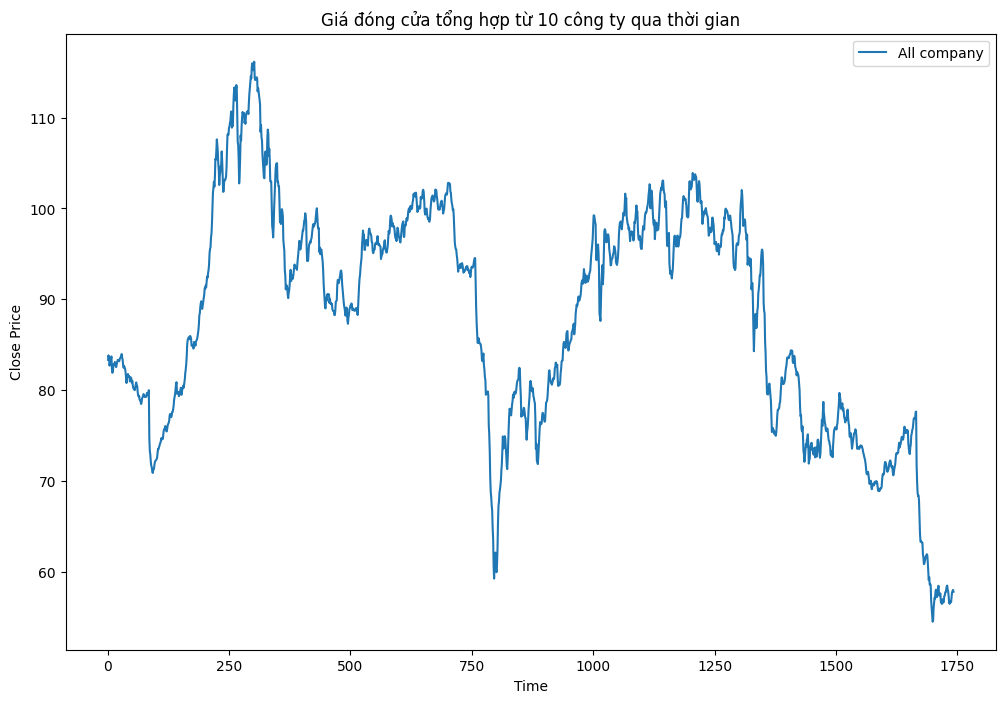

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Giá đóng cửa tổng hợp từ 10 công ty qua thời gian")

plt.plot(df.index, df.close, label="All company")

plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#ARIMA Model

In [ ]:
total = df['close']
trend_data = df['trend']
d = ndiffs(total, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [ ]:
close_diff = total.diff().dropna()

<Figure size 1800x600 with 0 Axes>

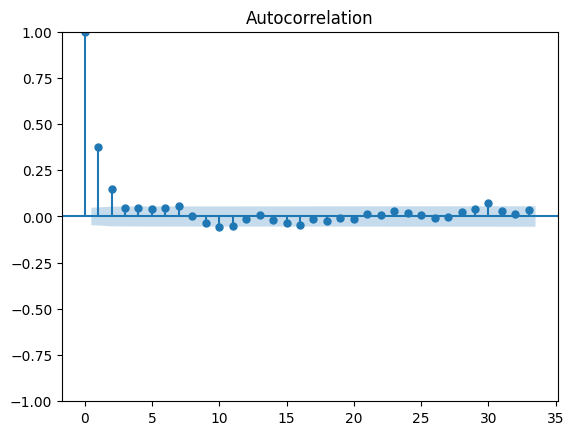

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_acf(close_diff)
plt.title("Autocorrelation")
plt.show()

<Figure size 1800x600 with 0 Axes>

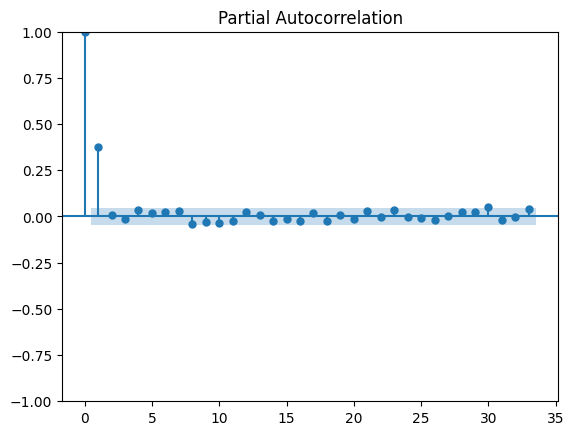

In [ ]:
plt.figure(figsize = (18,6))
ax = plot_pacf(close_diff)
plt.title("Partial Autocorrelation")
plt.show()

In [ ]:
train_len = int(len(total)*0.8)
train_data = total[:train_len]
test_data = total[train_len:]
trend_test = trend_data[train_len:]

In [ ]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data:', len(trend_test))

Train data:  1393
Test data:  349
Trend test data: 349


In [ ]:
model = ARIMA(train_data, order=(11,1,14))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1393
Model:               ARIMA(11, 1, 14)   Log Likelihood               -1580.421
Date:                Tue, 12 Mar 2024   AIC                           3212.842
Time:                        20:10:12   BIC                           3349.043
Sample:                             0   HQIC                          3263.772
                               - 1393                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6031      0.400      1.507      0.132      -0.181       1.388
ar.L2          0.5717      0.348      1.644      0.100      -0.110       1.253
ar.L3         -0.9290      0.394     -2.357      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


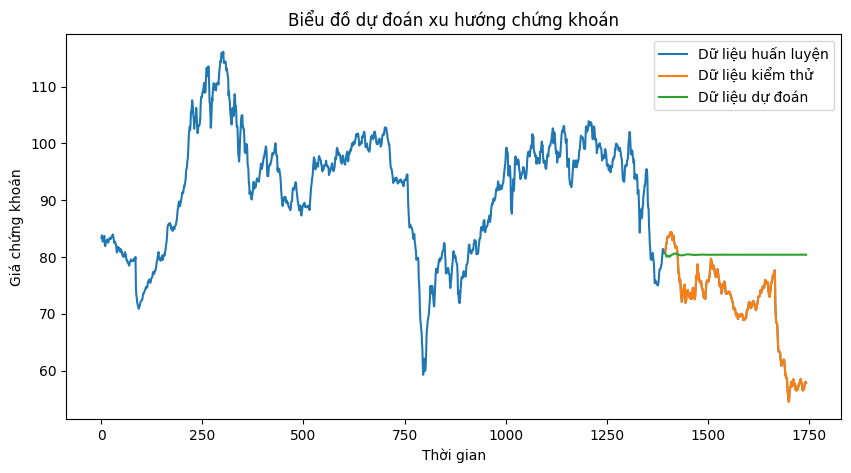

In [ ]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(total, label="Dữ liệu huấn luyện")
plt.plot(test_data, label="Dữ liệu kiểm thử")
plt.plot(predict_series, label="Dữ liệu dự đoán")

plt.title('Biểu đồ dự đoán xu hướng chứng khoán')
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán')
plt.legend()
plt.show()

In [ ]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1], index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.56


#The End